In [1]:
# contractions.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [2]:
# utils.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# We improve our feature matrix builder with 3 additional optional parameters
# This allows us to extract not only word features, but also n-gram features
# We can also set the minimum and maximum frequencies to be considered as valid
# NB: All these are simply passed on to sklearn's Vectorizer classes
def build_feature_matrix(documents, feature_type='frequency',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()

    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df,
                                     ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)

    return vectorizer, feature_matrix

In [3]:
#normalization.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# from contractions import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from html.parser import HTMLParser
import unicodedata

stopword_list = nltk.corpus.stopwords.words('english')
# We need to extend the stopword list for the domain we are working with
stopword_list = stopword_list + ['mr', 'mrs', 'come', 'go', 'get',
                                 'tell', 'listen', 'one', 'two', 'three',
                                 'four', 'five', 'six', 'seven', 'eight',
                                 'nine', 'zero', 'join', 'find', 'make',
                                 'say', 'ask', 'tell', 'see', 'try', 'back',
                                 'also']
wnl = WordNetLemmatizer()
html_parser = HTMLParser()

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# from pattern.en import tag (if using python 2.x only)
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):

    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tokens = nltk.word_tokenize(text)
    tagged_text = nltk.pos_tag(tokens)

#    tagged_text = tag(text) # If using pattern.en in python 2.x only
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

# lemmatize text based on POS tags
def lemmatize_text(text):

    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def unescape_html(parser, text):
    return parser.unescape(text)

# We generalize our normalize function to be able to focus on text tokens alone - 3rd parameter
def normalize_corpus(corpus, lemmatize=True, only_text_chars=False, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if only_text_chars:
            text = keep_text_characters(text)

        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)

    return normalized_corpus


def parse_document(document):
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    elif isinstance(document, encodingf='utf-8'):
        return unicodedata.normalize('NFKD', document).encode('ascii', 'ignore')
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences



In [4]:
#term_similarity.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

import numpy as np
# from scipy.stats import itemfreq

# Simplest representation of tokens is as a sequence of characters
def vectorize_terms(terms):
    terms = [term.lower() for term in terms]
    terms = [np.array(list(term)) for term in terms]
    terms = [np.array([ord(char) for char in term])
                for term in terms]
    return terms

# Another possibility is a bag of characters representation (without order constraint)
# We just use the frequency of each character as our word/token representation
def boc_term_vectors(word_list):
    word_list = [word.lower() for word in word_list]
    unique_chars = np.unique(
                        np.hstack([list(word)
                        for word in word_list]))
    word_list_term_counts = [dict(zip(*np.unique(list(word), return_counts=True)))
                         for word in word_list]

    boc_vectors = [np.array([int(word_term_counts.get(char, 0))
                            for char in unique_chars])
                   for word_term_counts in word_list_term_counts]
    return list(unique_chars), boc_vectors


root = 'Believe'
term1 = 'beleive'
term2 = 'bargain'
term3 = 'Elephant'

terms = [root, term1, term2, term3]

# Vectorize the root and the terms
vec_root, vec_term1, vec_term2, vec_term3 = vectorize_terms(terms)

# Show vector representations
print('''
root: {}
term1: {}
term2: {}
term3: {}
'''.format(vec_root, vec_term1, vec_term2, vec_term3))

# Vectorize root and terms in bag-of-characters representations
features, (boc_root, boc_term1, boc_term2, boc_term3) = boc_term_vectors(terms)
# Show the full list of features (all characters of all terms)
print('Features:', features)
# Show vector representation
print('''
root: {}
term1: {}
term2: {}
term3: {}
'''.format(boc_root, boc_term1, boc_term2, boc_term3))


# Catch the 'unequal length terms' exception for the metrics that rely on equal length terms
def hamming_distance(u, v, norm=False):
    max_length = max(len(u), len(v))
    u_padded = np.pad(u, (0, max_length - len(u)))
    v_padded = np.pad(v, (0, max_length - len(v)))

    return (u_padded != v_padded).sum() if not norm else (u_padded != v_padded).mean()

def manhattan_distance(u, v, norm=False):
    max_length = max(len(u), len(v))
    u_padded = np.pad(u, (0, max_length - len(u)))
    v_padded = np.pad(v, (0, max_length - len(v)))

    return abs(u_padded - v_padded).sum() if not norm else abs(u_padded - v_padded).mean()

def euclidean_distance(u, v):
    max_length = max(len(u), len(v))
    u_padded = np.pad(u, (0, max_length - len(u)))
    v_padded = np.pad(v, (0, max_length - len(v)))

    distance = np.sqrt(np.sum(np.square(u_padded - v_padded)))
    return distance


import copy
import pandas as pd

def levenshtein_edit_distance(u, v):
    # Convert to lower case
    u = u.lower()
    v = v.lower()
    # Base cases
    if u == v: return 0
    elif len(u) == 0: return len(v)
    elif len(v) == 0: return len(u)
    # Initialize edit distance matrix
    edit_matrix = []
    # Initialize two distance matrices
    du = [0] * (len(v) + 1)
    dv = [0] * (len(v) + 1)
    # du: the previous row of edit distances
    for i in range(len(du)):
        du[i] = i
    # dv : the current row of edit distances
    for i in range(len(u)):
        dv[0] = i + 1
        # Compute cost as per algorithm
        for j in range(len(v)):
            cost = 0 if u[i] == v[j] else 1
            dv[j + 1] = min(dv[j] + 1, du[j + 1] + 1, du[j] + cost)
        # Assign dv to du for next iteration
        for j in range(len(du)):
            du[j] = dv[j]
        # Copy dv to the edit matrix
        edit_matrix.append(copy.copy(dv))
    # Compute the final edit distance and edit matrix
    distance = dv[len(v)]
    edit_matrix = np.array(edit_matrix)
    edit_matrix = edit_matrix.T
    edit_matrix = edit_matrix[1:,]
    edit_matrix = pd.DataFrame(data=edit_matrix,
                               index=list(v),
                               columns=list(u))
    return distance, edit_matrix

def cosine_distance(u, v):
    distance = 1.0 - (np.dot(u, v) /
                        (np.sqrt(sum(np.square(u))) * np.sqrt(sum(np.square(v))))
                     )
    return distance



# Set up the term vectors
root_term = root
root_vector = vec_root
root_boc_vector = boc_root

terms = [term1, term2, term3]
vector_terms = [vec_term1, vec_term2, vec_term3]
boc_vector_terms = [boc_term1, boc_term2, boc_term3]


# HAMMING DISTANCE - will give error for unequal length terms
for term, vector_term in zip(terms, vector_terms):
    print('Hamming distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                hamming_distance(root_vector, vector_term, norm=False)))


for term, vector_term in zip(terms, vector_terms):
    print('Normalized Hamming distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(hamming_distance(root_vector, vector_term, norm=True), 2)))


# MANHATTAN DISTANCE - will give error for unequal length terms
for term, vector_term in zip(terms, vector_terms):
    print('Manhattan distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                manhattan_distance(root_vector, vector_term, norm=False)))

for term, vector_term in zip(terms, vector_terms):
    print('Normalized Manhattan distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(manhattan_distance(root_vector, vector_term, norm=True),2)))


# EUCLIDEAN DISTANCE - will give error for unequal length terms
for term, vector_term in zip(terms, vector_terms):
    print('Euclidean distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(euclidean_distance(root_vector, vector_term),2)))


# LEVENSHTEIN EDIT DISTANCE - doesn't depend on lengths of terms being equal (why?)
for term in terms:
    edit_d, edit_m = levenshtein_edit_distance(root_term, term)
    print('Computing distance between root: {} and term: {}'.format(root_term,
                                                                    term))
    print('Levenshtein edit distance is {}'.format(edit_d))
    print('The complete edit distance matrix is depicted below')
    print(edit_m)
    print('-'*30)


# COSINE DISTANCE\SIMILARITY - doesn't depend on lengths of terms being equal
for term, boc_term in zip(terms, boc_vector_terms):
    print('Analyzing similarity between root: {} and term: {}'.format(root_term,
                                                                      term))
    distance = round(cosine_distance(root_boc_vector, boc_term),2)
    similarity = 1 - distance
    print('Cosine distance  is {}'.format(distance))
    print('Cosine similarity  is {}'.format(similarity))
    print('-'*40)





root: [ 98 101 108 105 101 118 101]
term1: [ 98 101 108 101 105 118 101]
term2: [ 98  97 114 103  97 105 110]
term3: [101 108 101 112 104  97 110 116]

Features: ['a', 'b', 'e', 'g', 'h', 'i', 'l', 'n', 'p', 'r', 't', 'v']

root: [0 1 3 0 0 1 1 0 0 0 0 1]
term1: [0 1 3 0 0 1 1 0 0 0 0 1]
term2: [2 1 0 1 0 1 0 1 0 1 0 0]
term3: [1 0 2 0 1 0 1 1 1 0 1 0]

Hamming distance between root: Believe and term: beleive is 2
Hamming distance between root: Believe and term: bargain is 6
Hamming distance between root: Believe and term: Elephant is 8
Normalized Hamming distance between root: Believe and term: beleive is 0.29
Normalized Hamming distance between root: Believe and term: bargain is 0.86
Normalized Hamming distance between root: Believe and term: Elephant is 1.0
Manhattan distance between root: Believe and term: beleive is 8
Manhattan distance between root: Believe and term: bargain is 38
Manhattan distance between root: Believe and term: Elephant is 173
Normalized Manhattan distance be

                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...
Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks 

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


dict_items([(3, 21), (2, 23), (1, 22), (4, 27), (0, 7)])
Cluster 0 details:
--------------------
Key features: ['child', 'girl', 'town', 'love', 'marry']
Movies in this cluster:
The Sound of Music, The Philadelphia Story, To Kill a Mockingbird, High Noon, City Lights, Terms of Endearment, Wuthering Heights
Cluster 1 details:
--------------------
Key features: ['soldier', 'men', 'kill', 'army', 'war']
Movies in this cluster:
Schindler's List, Raging Bull, Gone with the Wind, Lawrence of Arabia, On the Waterfront, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Patton, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, Platoon, Dances with Wolves, The Deer Hunter, All Quiet on the Western Front, Shane, Mutiny on the Bounty
Cluster 2 details:
--------------------
Key features: ['

C:\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


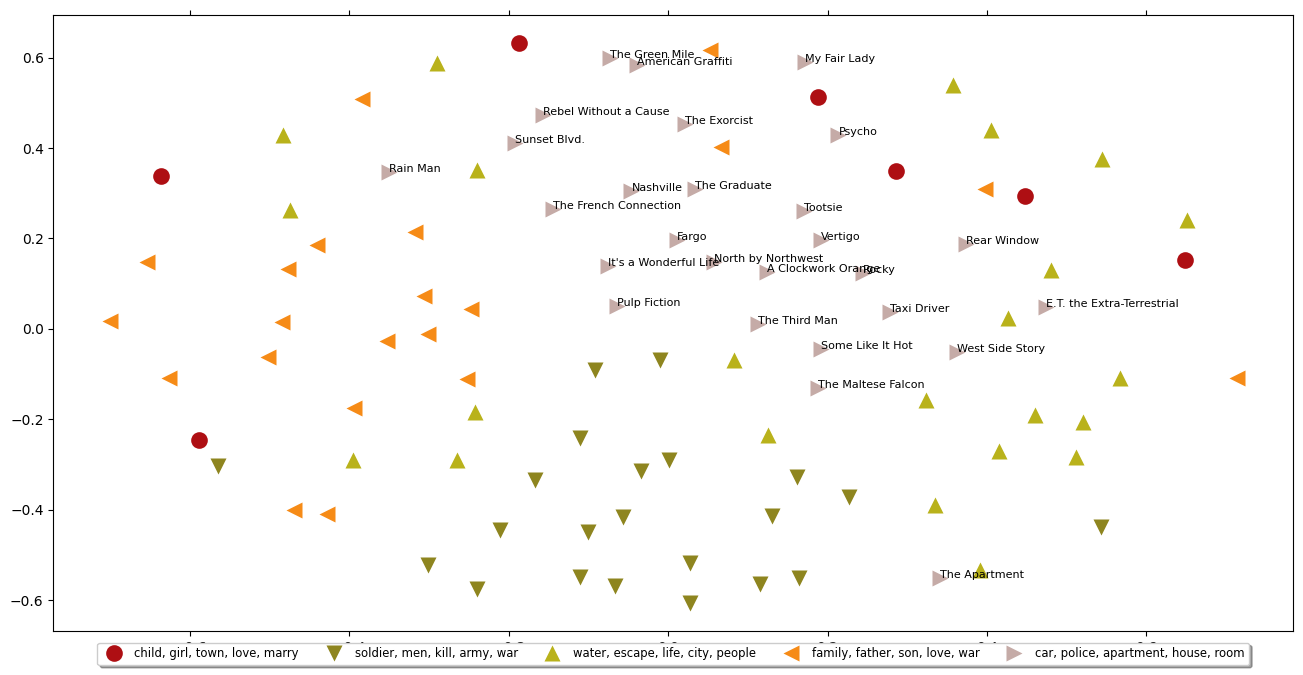

dict_items([(0, 5), (2, 12), (6, 9), (11, 4), (1, 6), (16, 8), (3, 7), (13, 7), (8, 4), (9, 9), (12, 5), (4, 2), (5, 5), (7, 7), (14, 4), (15, 3), (10, 3)])
Total Clusters: 17
Cluster 0 details:
--------------------
Key features: ['able', 'another', 'daughter', 'entire', 'enter']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: ['allow', 'across', 'arrest', 'alive', 'become']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: ['appear', 'finish', 'fire', 'father', 'enough']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: ['arrive', 'fi

C:\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


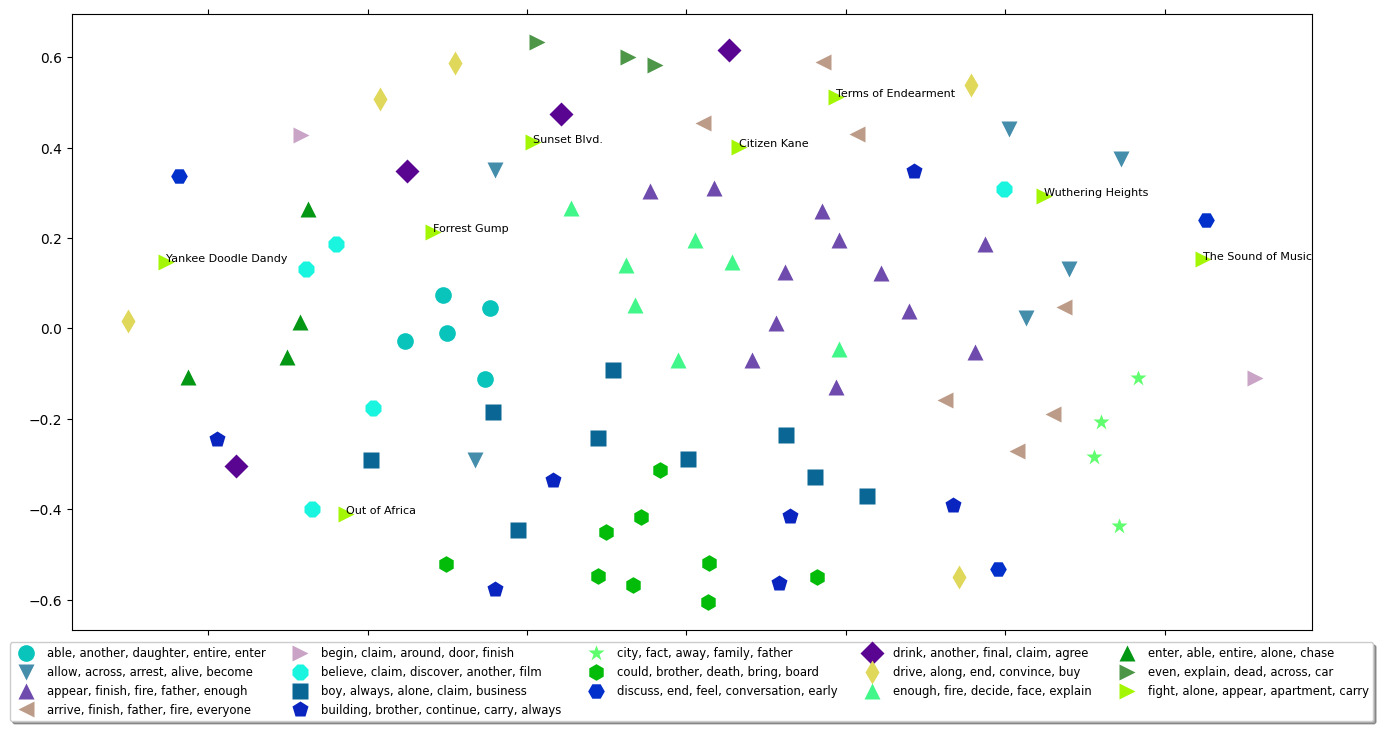

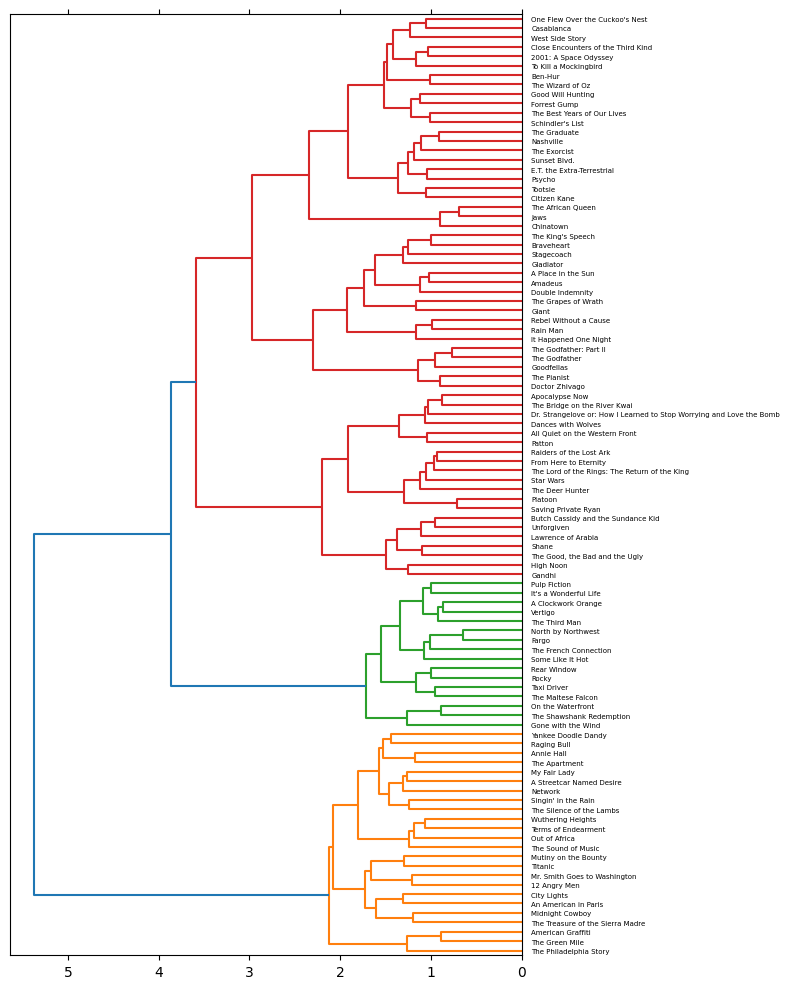

In [5]:
#document_clustering.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: aw
"""

import pandas as pd
import numpy as np

# Load the movie data from local file
movie_data = pd.read_csv('movie_data.csv')
# View the beginning to ensure all is ok
print(movie_data.head())

movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

# Show the first movie title and synopsis
print('Movie:', movie_titles[0])
print('Movie Synopsis:', movie_synopses[0][:1000])


# from normalization import normalize_corpus
# from utils import build_feature_matrix

# Normalize the corpus as usual
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

# Extract (tf-idf) features using out utils library
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# How many features do we have?
print(feature_matrix.shape)

# Get the names of the features
feature_names = vectorizer.get_feature_names_out()

# Show the first twenty features (check more if needed)
print(feature_names[:20])


from sklearn.cluster import KMeans

# Define the k-means clustering function which will call sklearn's KMeans function
# with our parameters
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

# We will assume that we want the 100 movies divided into 5 clusters (try other values)
num_clusters = 5
# Call the above function to get clusters and assign the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters


from collections import Counter
# Get the total number of movies per cluster
c = Counter(clusters)
print(c.items())

# We define a generic function to extract details of the clusters we get (from each of our algorithms)
def get_cluster_data(clustering_obj, movie_data,
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}
    # Get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # Get key features for each cluster
    # Get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index]
                        for index
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features

        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies

    return cluster_details


# We also define a simple function to print the data we extracted with the above function
def print_cluster_data(cluster_data):
    # Print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('Movies in this cluster:')
        print(', '.join(cluster_details['movies']))
        print('='*40)



# We want to be able to visualize the clusters that we got
# Since these will mostly be for multidimensional data, we need to reduce their dimensionality
# We use sklearn's multidimensional scaling (MDS) algorithm to do this
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

# This is not a regular function - it has no return value, but only a 'side effect' (plotting)
# This is a generic function to plot the output of any clustering algorithm with dynamic # of clusters
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16, 8)):
    # Generate random colors for clusters
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # Define different markers for clusters
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # Build the cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    # Reduce the dimensionality (in this case to 2) using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed",
              random_state=1)
    # Get the coordinates of clusters in the new low-dimensional (2-dim) space
    plot_positions = mds.fit_transform(cosine_distance)
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # Set up the cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # Assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # Map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # Set the figure size and axes of the plot
    fig, ax = plt.subplots(figsize=plot_size)
    ax.margins(0.05)
    # Plot each cluster with its co-ordinates and the corresponding movie title
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'],
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num],
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True,
              shadow=True, ncol=5, numpoints=1, prop=fontP)
    # Add labels as necessary
    for index, cluster_row in cluster_frame.iterrows():
       ax.text(cluster_row['x'],
                cluster_row['y'],
                cluster_row['title'], size=8)


    # Finally show the plot (only when this is called will the plot be displayed)
    plt.show()


# Analyse the k-means clustering data
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)

# Print the detailed clustering analysis results
print_cluster_data(cluster_data)

# Now visualize the clusters produced
plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
              cluster_data=cluster_data,
              movie_data=movie_data,
              plot_size=(16,8))




# We now repeat the steps of performing clustering using a different algorithm: AP
from sklearn.cluster import AffinityPropagation

from sklearn.cluster import AffinityPropagation

def affinity_propagation(feature_matrix):
    sim = feature_matrix * feature_matrix.T
    sim = np.asarray(sim.todense())  # Convert to a dense NumPy array
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_
    return ap, clusters


# Get clusters using affinity propagation (AP)
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

# Get the total number of movies per cluster as before
c = Counter(clusters)
print(c.items())

# How many clusters are there in total?
total_clusters = len(c)
print('Total Clusters:', total_clusters)

# Get clustering analysis data using our generic function
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)
# Print clustering analysis results
print_cluster_data(cluster_data)

# Visualize the clusters as before using our generic function
plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
              cluster_data=cluster_data,
              movie_data=movie_data,
              plot_size=(16,8))




# We finally repeat the steps of performing clustering again for Hierarchical clustering
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):

    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

# Plotting hierarchical plot objects is different to 'partitioned' (hard) clusters
# since they need to be plotted as a dendrogram and not points on a 2-dim graph
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # Set the size of the plot using pyplot (from matplotlib)
    fig, ax = plt.subplots(figsize=figure_size)
    movie_titles = movie_data['Title'].values.tolist()
    # Plot the dendrogram for the given plot object
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',
                    which='both',
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# Build ward's linkage matrix by calling the above function
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# Plot the clustering output as a dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))



In [6]:
#document_similarity.py
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# from normalization import normalize_corpus
# from utils import build_feature_matrix
import numpy as np

# We define a toy corpus (collection of documents) to explore the ideas
toy_corpus = ['The sky is blue',
'The sky is blue and beautiful',
'Look at the bright blue sky!',
'Python is a great Programming language',
'Python and Java are popular Programming languages',
'Among Programming languages, both Python and Java are the most used in Analytics',
'The fox is quicker than the lazy dog',
'The dog is smarter than the fox',
'The dog, fox and cat are good friends']

# Documents that we will be measuring similarities for
query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']


# We normalize and extract features from the toy corpus
norm_corpus = normalize_corpus(toy_corpus, lemmatize=True)
# NB: As before it returns the particular 'vectorizer' used as well as the extracted feature matrix
tfidf_vectorizer, tfidf_features = build_feature_matrix(norm_corpus,
                                                        feature_type='tfidf',
                                                        ngram_range=(1, 1),
                                                        min_df=0.0, max_df=1.0)

# Similarly, we normalize and extract features from the query corpus
norm_query_docs =  normalize_corpus(query_docs, lemmatize=True)
# We use the same vectorizer that we used to build the feature matrix for the corpus also for query doc
query_docs_tfidf = tfidf_vectorizer.transform(norm_query_docs)

def compute_cosine_similarity(doc_features, corpus_features,
                              top_n=3):
    # Get document vectors
    doc_features = doc_features[0]
    # Compute similarities by calling dot.product on transposed corpus feature vector
    similarity = np.dot(doc_features,
                        corpus_features.T)
    similarity = similarity.toarray()[0]
    # Get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    return top_docs_with_score


# Get Cosine similarity results for our example documents
print('Document Similarity Analysis using Cosine Similarity')
print('='*60)
for index, doc in enumerate(query_docs):

    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf,
                                             tfidf_features,
                                             top_n=2)
    print('Document',index+1 ,':', doc)
    print('Top', len(top_similar_docs), 'similar docs:')
    print('-'*40)
    for doc_index, sim_score in top_similar_docs:
        print('Doc num: {} Similarity Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index]))
        print('-'*40)
    print()


def compute_hellinger_bhattacharya_distance(doc_features, corpus_features,
                                            top_n=3):
    # Get document vectors
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # Compute HB distances
    distance = np.hstack(
                    np.sqrt(0.5 *
                            np.sum(
                                np.square(np.sqrt(doc_features) -
                                          np.sqrt(corpus_features)),
                                axis=1)))
    # Get docs with lowest distance scores
    top_docs = distance.argsort()[:top_n]
    top_docs_with_score = [(index, round(distance[index], 3))
                            for index in top_docs]
    return top_docs_with_score

# Get Hellinger-Bhattacharya distance based similarities for our example
print('Document Similarity Analysis using Hellinger-Bhattacharya distance')
print('='*60)
for index, doc in enumerate(query_docs):

    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_hellinger_bhattacharya_distance(doc_tfidf,
                                             tfidf_features,
                                             top_n=2)
    print('Document',index+1 ,':', doc)
    print('Top', len(top_similar_docs), 'similar docs:')
    print('-'*40)
    for doc_index, sim_score in top_similar_docs:
        print('Doc num: {} Distance Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index]))
        print('-'*40)
    print()


import scipy.sparse as sp

def compute_corpus_term_idfs(corpus_features, norm_corpus):

    dfs = np.diff(sp.csc_matrix(corpus_features, copy=True).indptr)
    dfs = 1 + dfs # to smoothen idf later
    total_docs = 1 + len(norm_corpus)
    idfs = 1.0 + np.log(float(total_docs) / dfs)
    return idfs


def compute_bm25_similarity(doc_features, corpus_features,
                            corpus_doc_lengths, avg_doc_length,
                            term_idfs, k1=1.5, b=0.75, top_n=3):
    # Get corpus bag of words features
    corpus_features = corpus_features.toarray()
    # convert query document features to binary features
    # this is to keep a note of which terms exist per document
    doc_features = doc_features.toarray()[0]
    doc_features[doc_features >= 1] = 1

    # Compute the document idf scores for present terms
    doc_idfs = doc_features * term_idfs
    # compute numerator expression in BM25 equation
    numerator_coeff = corpus_features * (k1 + 1)
    numerator = np.multiply(doc_idfs, numerator_coeff)
    # Compute denominator expression in BM25 equation
    denominator_coeff =  k1 * (1 - b +
                                (b * (corpus_doc_lengths /
                                        avg_doc_length)))
    denominator_coeff = np.vstack(denominator_coeff)
    denominator = corpus_features + denominator_coeff
    # Compute the BM25 score combining the above equations
    bm25_scores = np.sum(np.divide(numerator,
                                   denominator),
                         axis=1)
    # Get top n relevant docs with highest BM25 score
    top_docs = bm25_scores.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(bm25_scores[index], 3))
                            for index in top_docs]
    return top_docs_with_score

# Build bag of words based features first
vectorizer, corpus_features = build_feature_matrix(norm_corpus,
                                                   feature_type='frequency')
# We use the same vectorizer that we used to build the feature matrix for the corpus also for query doc
query_docs_features = vectorizer.transform(norm_query_docs)

# Get average document length of the corpus (avgdl)
doc_lengths = [len(doc.split()) for doc in norm_corpus]
avg_dl = np.average(doc_lengths)

# Get the corpus term idfs
corpus_term_idfs = compute_corpus_term_idfs(corpus_features,
                                            norm_corpus)

# Analyze document similarity using BM25 framework
print('Document Similarity Analysis using BM25')
print('='*60)
for index, doc in enumerate(query_docs):

    doc_features = query_docs_features[index]
    top_similar_docs = compute_bm25_similarity(doc_features,
                                               corpus_features,
                                               doc_lengths,
                                               avg_dl,
                                               corpus_term_idfs,
                                               k1=1.5, b=0.75,
                                               top_n=2)
    print('Document',index+1 ,':', doc)
    print('Top', len(top_similar_docs), 'similar docs:')
    print('-'*40)
    for doc_index, sim_score in top_similar_docs:
        print('Doc num: {} BM25 Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index]))
        print('-'*40)
    print()



Document Similarity Analysis using Cosine Similarity
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 8 Similarity Score: 1.0
Doc: The dog is smarter than the fox
----------------------------------------
Doc num: 7 Similarity Score: 0.426
Doc: The fox is quicker than the lazy dog
----------------------------------------

Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 5 Similarity Score: 0.733
Doc: Python and Java are popular Programming languages
----------------------------------------
Doc num: 6 Similarity Score: 0.58
Doc: Among Programming languages, both Python and Java are the most used in Analytics
----------------------------------------

Document 3 : I love to relax under the beautiful blue sky!
Top 2 similar docs:
----------------------------------------
Doc num: 2 Similarity Score: 1.0
Doc: The sky is blue a

In [7]:
nltk.download('names')
import nltk
import random
from nltk.corpus import names

def gender_features(word):
  return{'last_letter': word[-1]}

gender_features('Shrek')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


{'last_letter': 'k'}

In [8]:
names.words('male.txt')[:20]

['Aamir',
 'Aaron',
 'Abbey',
 'Abbie',
 'Abbot',
 'Abbott',
 'Abby',
 'Abdel',
 'Abdul',
 'Abdulkarim',
 'Abdullah',
 'Abe',
 'Abel',
 'Abelard',
 'Abner',
 'Abraham',
 'Abram',
 'Ace',
 'Adair',
 'Adam']

In [9]:
namesgender = (
    [(name, 'male') for name in names.words('male.txt')] 
    +[(name, 'female') for name in names.words('female.txt')]
)
len(namesgender)

7944

In [10]:
namesgender[7924:]

[('Zena', 'female'),
 ('Zenia', 'female'),
 ('Zia', 'female'),
 ('Zilvia', 'female'),
 ('Zita', 'female'),
 ('Zitella', 'female'),
 ('Zoe', 'female'),
 ('Zola', 'female'),
 ('Zonda', 'female'),
 ('Zondra', 'female'),
 ('Zonnya', 'female'),
 ('Zora', 'female'),
 ('Zorah', 'female'),
 ('Zorana', 'female'),
 ('Zorina', 'female'),
 ('Zorine', 'female'),
 ('Zsa Zsa', 'female'),
 ('Zsazsa', 'female'),
 ('Zulema', 'female'),
 ('Zuzana', 'female')]

In [11]:
import random
random.shuffle(namesgender)
namesgender[:20]

[('Saxon', 'male'),
 ('Gerrie', 'female'),
 ('Gennie', 'female'),
 ('Dominique', 'male'),
 ('Milka', 'female'),
 ('Teodora', 'female'),
 ('Natale', 'male'),
 ('Rick', 'male'),
 ('Fonzie', 'male'),
 ('Gordon', 'male'),
 ('Maybelle', 'female'),
 ('Remus', 'male'),
 ('Hal', 'male'),
 ('Juergen', 'male'),
 ('Ninon', 'female'),
 ('Torrance', 'male'),
 ('Dea', 'female'),
 ('Fredi', 'female'),
 ('Warren', 'male'),
 ('Claudie', 'female')]

In [12]:
featuresets = [(gender_features(n), g) for (n,g) in namesgender]
featuresets[:20]

[({'last_letter': 'n'}, 'male'),
 ({'last_letter': 'e'}, 'female'),
 ({'last_letter': 'e'}, 'female'),
 ({'last_letter': 'e'}, 'male'),
 ({'last_letter': 'a'}, 'female'),
 ({'last_letter': 'a'}, 'female'),
 ({'last_letter': 'e'}, 'male'),
 ({'last_letter': 'k'}, 'male'),
 ({'last_letter': 'e'}, 'male'),
 ({'last_letter': 'n'}, 'male'),
 ({'last_letter': 'e'}, 'female'),
 ({'last_letter': 's'}, 'male'),
 ({'last_letter': 'l'}, 'male'),
 ({'last_letter': 'n'}, 'male'),
 ({'last_letter': 'n'}, 'female'),
 ({'last_letter': 'e'}, 'male'),
 ({'last_letter': 'a'}, 'female'),
 ({'last_letter': 'i'}, 'female'),
 ({'last_letter': 'n'}, 'male'),
 ({'last_letter': 'e'}, 'female')]

In [13]:
train_set, test_set = featuresets[500:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (nltk.classify.accuracy(classifier, test_set))

0.772


In [14]:
classifier.classify(gender_features('Neo'))

'male'

In [15]:
classifier.classify(gender_features('Trinity'))

'female'

In [16]:
classifier.show_most_informative_features(20)

Most Informative Features
             last_letter = 'a'            female : male   =     34.7 : 1.0
             last_letter = 'k'              male : female =     30.9 : 1.0
             last_letter = 'f'              male : female =     16.0 : 1.0
             last_letter = 'p'              male : female =     12.6 : 1.0
             last_letter = 'v'              male : female =     11.3 : 1.0
             last_letter = 'd'              male : female =      9.6 : 1.0
             last_letter = 'm'              male : female =      8.9 : 1.0
             last_letter = 'o'              male : female =      8.3 : 1.0
             last_letter = 'r'              male : female =      6.9 : 1.0
             last_letter = 'w'              male : female =      5.1 : 1.0
             last_letter = 'g'              male : female =      4.8 : 1.0
             last_letter = 'z'              male : female =      4.4 : 1.0
             last_letter = 't'              male : female =      4.2 : 1.0

In [17]:
def gender_features2(name):
  features = {}
  features["firstletter"] = name[0].lower()
  features["lastletter"] = name[-1].lower()

  for letter in 'abcdefghijklmnopqrstuvwxyz':
      features["count(%s)" % letter] = name.lower().count(letter)
      features["has(%s)" % letter] = (letter in name.lower())
  return features
features = gender_features2('Shrek')
len(features)

54

In [18]:
features

{'firstletter': 's',
 'lastletter': 'k',
 'count(a)': 0,
 'has(a)': False,
 'count(b)': 0,
 'has(b)': False,
 'count(c)': 0,
 'has(c)': False,
 'count(d)': 0,
 'has(d)': False,
 'count(e)': 1,
 'has(e)': True,
 'count(f)': 0,
 'has(f)': False,
 'count(g)': 0,
 'has(g)': False,
 'count(h)': 1,
 'has(h)': True,
 'count(i)': 0,
 'has(i)': False,
 'count(j)': 0,
 'has(j)': False,
 'count(k)': 1,
 'has(k)': True,
 'count(l)': 0,
 'has(l)': False,
 'count(m)': 0,
 'has(m)': False,
 'count(n)': 0,
 'has(n)': False,
 'count(o)': 0,
 'has(o)': False,
 'count(p)': 0,
 'has(p)': False,
 'count(q)': 0,
 'has(q)': False,
 'count(r)': 1,
 'has(r)': True,
 'count(s)': 1,
 'has(s)': True,
 'count(t)': 0,
 'has(t)': False,
 'count(u)': 0,
 'has(u)': False,
 'count(v)': 0,
 'has(v)': False,
 'count(w)': 0,
 'has(w)': False,
 'count(x)': 0,
 'has(x)': False,
 'count(y)': 0,
 'has(y)': False,
 'count(z)': 0,
 'has(z)': False}

In [19]:
featuresets2 = [(gender_features2(n), g) for (n,g) in namesgender]
for (n,g) in namesgender[:5]:
  print (n, gender_features2(n), '\n')

Saxon {'firstletter': 's', 'lastletter': 'n', 'count(a)': 1, 'has(a)': True, 'count(b)': 0, 'has(b)': False, 'count(c)': 0, 'has(c)': False, 'count(d)': 0, 'has(d)': False, 'count(e)': 0, 'has(e)': False, 'count(f)': 0, 'has(f)': False, 'count(g)': 0, 'has(g)': False, 'count(h)': 0, 'has(h)': False, 'count(i)': 0, 'has(i)': False, 'count(j)': 0, 'has(j)': False, 'count(k)': 0, 'has(k)': False, 'count(l)': 0, 'has(l)': False, 'count(m)': 0, 'has(m)': False, 'count(n)': 1, 'has(n)': True, 'count(o)': 1, 'has(o)': True, 'count(p)': 0, 'has(p)': False, 'count(q)': 0, 'has(q)': False, 'count(r)': 0, 'has(r)': False, 'count(s)': 1, 'has(s)': True, 'count(t)': 0, 'has(t)': False, 'count(u)': 0, 'has(u)': False, 'count(v)': 0, 'has(v)': False, 'count(w)': 0, 'has(w)': False, 'count(x)': 1, 'has(x)': True, 'count(y)': 0, 'has(y)': False, 'count(z)': 0, 'has(z)': False} 

Gerrie {'firstletter': 'g', 'lastletter': 'e', 'count(a)': 0, 'has(a)': False, 'count(b)': 0, 'has(b)': False, 'count(c)': 0,

In [20]:
train_set, test_set = featuresets2[500:], featuresets2[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (nltk.classify.accuracy(classifier, test_set))

0.786


In [21]:
train_names = namesgender[1500:]
devtest_names = namesgender[500:1500]
test_names = namesgender[:500]
train_set = [(gender_features(n), g) for (n,g) in train_names]
devtest_set = [(gender_features(n), g) for (n,g) in devtest_names]
test_set = [(gender_features(n), g) for (n,g) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print (nltk.classify.accuracy(classifier, devtest_set))

0.758


In [22]:
def geterrors(devtest):
  errors = []
  for (name, tag) in devtest:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
      errors.append( (tag, guess, name) )
  return errors

errors = geterrors(devtest_names)
len(errors)

242

In [23]:
def printerrors(errors):
  for (tag, guess, name) in sorted(errors):
    print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

printerrors(errors)

correct=female   guess=male     name=Abagael                       
correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Adelind                       
correct=female   guess=male     name=Adriaens                      
correct=female   guess=male     name=Aileen                        
correct=female   guess=male     name=Ailyn                         
correct=female   guess=male     name=Aimil                         
correct=female   guess=male     name=Alyss                         
correct=female   guess=male     name=Amabel                        
correct=female   guess=male     name=Arabel                        
correct=female   guess=male     name=Arlen                         
correct=female   guess=male     name=Arlyn                         
correct=female   guess=male     name=Austin                        
correct=female   guess=male     name=Avis                          
correct=female   guess=male     name=Bel        

In [24]:
# Define a new feature extraction function that includes two-letter suffixes
def gender_features3(word):
  return {'suffix1': word[-1],
          'suffix2': word[-2]}

gender_features3('Shrek')

{'suffix1': 'k', 'suffix2': 'e'}

In [25]:
featuresets3 = [(gender_features3(n), g) for (n,g) in namesgender]
featuresets3[:20]

[({'suffix1': 'n', 'suffix2': 'o'}, 'male'),
 ({'suffix1': 'e', 'suffix2': 'i'}, 'female'),
 ({'suffix1': 'e', 'suffix2': 'i'}, 'female'),
 ({'suffix1': 'e', 'suffix2': 'u'}, 'male'),
 ({'suffix1': 'a', 'suffix2': 'k'}, 'female'),
 ({'suffix1': 'a', 'suffix2': 'r'}, 'female'),
 ({'suffix1': 'e', 'suffix2': 'l'}, 'male'),
 ({'suffix1': 'k', 'suffix2': 'c'}, 'male'),
 ({'suffix1': 'e', 'suffix2': 'i'}, 'male'),
 ({'suffix1': 'n', 'suffix2': 'o'}, 'male'),
 ({'suffix1': 'e', 'suffix2': 'l'}, 'female'),
 ({'suffix1': 's', 'suffix2': 'u'}, 'male'),
 ({'suffix1': 'l', 'suffix2': 'a'}, 'male'),
 ({'suffix1': 'n', 'suffix2': 'e'}, 'male'),
 ({'suffix1': 'n', 'suffix2': 'o'}, 'female'),
 ({'suffix1': 'e', 'suffix2': 'c'}, 'male'),
 ({'suffix1': 'a', 'suffix2': 'e'}, 'female'),
 ({'suffix1': 'i', 'suffix2': 'd'}, 'female'),
 ({'suffix1': 'n', 'suffix2': 'e'}, 'male'),
 ({'suffix1': 'e', 'suffix2': 'i'}, 'female')]

In [26]:
train_set3, test_set3 = featuresets3[500:], featuresets3[:500]
classifier3 = nltk.NaiveBayesClassifier.train(train_set3)
print (nltk.classify.accuracy(classifier3, test_set3))

0.766


In [27]:
classifier3.classify(gender_features3('Neo'))

'male'

In [28]:
classifier3.classify(gender_features3('Trinity'))

'female'

In [29]:
classifier3.show_most_informative_features(20)

Most Informative Features
                 suffix1 = 'a'            female : male   =     34.7 : 1.0
                 suffix1 = 'k'              male : female =     30.9 : 1.0
                 suffix1 = 'f'              male : female =     16.0 : 1.0
                 suffix1 = 'p'              male : female =     12.6 : 1.0
                 suffix1 = 'v'              male : female =     11.3 : 1.0
                 suffix1 = 'd'              male : female =      9.6 : 1.0
                 suffix1 = 'm'              male : female =      8.9 : 1.0
                 suffix1 = 'o'              male : female =      8.3 : 1.0
                 suffix2 = 'o'              male : female =      8.0 : 1.0
                 suffix2 = 'u'              male : female =      7.2 : 1.0
                 suffix1 = 'r'              male : female =      6.9 : 1.0
                 suffix1 = 'w'              male : female =      5.1 : 1.0
                 suffix2 = 'E'              male : female =      5.1 : 1.0

In [30]:
devtest_set3 = [(gender_features3(n), g) for (n,g) in devtest_names]

In [31]:
def geterrors3(devtest):
  errors = []
  for (name, tag) in devtest:
    guess = classifier3.classify(gender_features3(name))
    if guess != tag:
      errors.append( (tag, guess, name) )
  return errors

errors3 = geterrors3(devtest_names)
len(errors3)

248

In [32]:
def printerrors(errors):
  for (tag, guess, name) in sorted(errors3):
    print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))
    
printerrors(errors3)

correct=female   guess=male     name=Abagael                       
correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Adelind                       
correct=female   guess=male     name=Aileen                        
correct=female   guess=male     name=Alyss                         
correct=female   guess=male     name=Amabel                        
correct=female   guess=male     name=Ansley                        
correct=female   guess=male     name=Arabel                        
correct=female   guess=male     name=Arlen                         
correct=female   guess=male     name=Austin                        
correct=female   guess=male     name=Avis                          
correct=female   guess=male     name=Barbey                        
correct=female   guess=male     name=Bel                           
correct=female   guess=male     name=Beret                         
correct=female   guess=male     name=Brigit     

In [33]:
from nltk.corpus import brown
suffix_fdist = nltk.FreqDist()
for word in brown.words():
    word = word.lower()
    suffix_fdist.update([word[-1:]])
    suffix_fdist.update([word[-2:]])
    suffix_fdist.update([word[-3:]])

common_suffixes = list(suffix_fdist.keys())[:100]
print (common_suffixes)

['e', 'he', 'the', 'n', 'on', 'ton', 'y', 'ty', 'nty', 'd', 'nd', 'and', 'ry', 'ury', 'id', 'aid', 'ay', 'day', 'an', 'ion', 'f', 'of', 's', "'s", "a's", 't', 'nt', 'ent', 'ary', 'ed', 'ced', '`', '``', 'o', 'no', 'ce', 'nce', "'", "''", 'at', 'hat', 'ny', 'any', 'es', 'ies', 'k', 'ok', 'ook', 'ace', '.', 'r', 'er', 'her', 'in', 'end', 'ts', 'nts', 'ity', 've', 'ive', 'ee', 'tee', ',', 'h', 'ch', 'ich', 'ad', 'had', 'l', 'll', 'all', 'ge', 'rge', 'ves', 'se', 'ise', 'ks', 'nks', 'a', 'ta', 'nta', 'or', 'for', 'ner', 'as', 'was', 'ted', 'ber', 'm', 'rm', 'erm', 'en', 'een', 'ged', 'by', 'ior', 'rt', 'urt', 'dge', 'od']


In [34]:
def pos_features(word):
    features = {}
    for suffix in common_suffixes:
        features[f'endswith({suffix})'] = word.lower().endswith(suffix)

    return features

pos_features('lovely')

{'endswith(e)': False,
 'endswith(he)': False,
 'endswith(the)': False,
 'endswith(n)': False,
 'endswith(on)': False,
 'endswith(ton)': False,
 'endswith(y)': True,
 'endswith(ty)': False,
 'endswith(nty)': False,
 'endswith(d)': False,
 'endswith(nd)': False,
 'endswith(and)': False,
 'endswith(ry)': False,
 'endswith(ury)': False,
 'endswith(id)': False,
 'endswith(aid)': False,
 'endswith(ay)': False,
 'endswith(day)': False,
 'endswith(an)': False,
 'endswith(ion)': False,
 'endswith(f)': False,
 'endswith(of)': False,
 'endswith(s)': False,
 "endswith('s)": False,
 "endswith(a's)": False,
 'endswith(t)': False,
 'endswith(nt)': False,
 'endswith(ent)': False,
 'endswith(ary)': False,
 'endswith(ed)': False,
 'endswith(ced)': False,
 'endswith(`)': False,
 'endswith(``)': False,
 'endswith(o)': False,
 'endswith(no)': False,
 'endswith(ce)': False,
 'endswith(nce)': False,
 "endswith(')": False,
 "endswith('')": False,
 'endswith(at)': False,
 'endswith(hat)': False,
 'endswith(ny

In [35]:
pos_features('expansion')

{'endswith(e)': False,
 'endswith(he)': False,
 'endswith(the)': False,
 'endswith(n)': True,
 'endswith(on)': True,
 'endswith(ton)': False,
 'endswith(y)': False,
 'endswith(ty)': False,
 'endswith(nty)': False,
 'endswith(d)': False,
 'endswith(nd)': False,
 'endswith(and)': False,
 'endswith(ry)': False,
 'endswith(ury)': False,
 'endswith(id)': False,
 'endswith(aid)': False,
 'endswith(ay)': False,
 'endswith(day)': False,
 'endswith(an)': False,
 'endswith(ion)': True,
 'endswith(f)': False,
 'endswith(of)': False,
 'endswith(s)': False,
 "endswith('s)": False,
 "endswith(a's)": False,
 'endswith(t)': False,
 'endswith(nt)': False,
 'endswith(ent)': False,
 'endswith(ary)': False,
 'endswith(ed)': False,
 'endswith(ced)': False,
 'endswith(`)': False,
 'endswith(``)': False,
 'endswith(o)': False,
 'endswith(no)': False,
 'endswith(ce)': False,
 'endswith(nce)': False,
 "endswith(')": False,
 "endswith('')": False,
 'endswith(at)': False,
 'endswith(hat)': False,
 'endswith(ny)'

In [36]:
def pos_features(sentence, i):
  features = {"suffix(1)": sentence[i][-1:],
    "suffix(2)": sentence[i][-2:],
    "suffix(3)": sentence[i][-3:]}
  if i == 0:
    features["prev-word"] = "<START>"
  else:
    features["prev-word"] = sentence[i-1]
  return features

In [37]:
 brown.sents()[0]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.']

In [38]:
pos_features(brown.sents()[0], 8)

{'suffix(1)': 'n', 'suffix(2)': 'on', 'suffix(3)': 'ion', 'prev-word': 'an'}

In [39]:
tagged_sents = brown.tagged_sents(categories='news')

In [40]:
for tagged_sent in tagged_sents:
  untagged_sent = nltk.tag.untag(tagged_sent)
  for i, (word, tag) in enumerate(tagged_sent):
    featuresets.append( (pos_features(untagged_sent, i), tag) )

for f in featuresets[:10]:
  print (f)

({'last_letter': 'n'}, 'male')
({'last_letter': 'e'}, 'female')
({'last_letter': 'e'}, 'female')
({'last_letter': 'e'}, 'male')
({'last_letter': 'a'}, 'female')
({'last_letter': 'a'}, 'female')
({'last_letter': 'e'}, 'male')
({'last_letter': 'k'}, 'male')
({'last_letter': 'e'}, 'male')
({'last_letter': 'n'}, 'male')


In [41]:
size = int(len(featuresets) * 0.1)
train_set, test_set = featuresets[size:], featuresets[:size]
len(train_set)

97649

In [42]:
len(test_set)

10849

In [43]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.21568808185086183


In [44]:
sents = nltk.corpus.treebank_raw.sents()
sents[:10]

[['.', 'START'],
 ['Pierre',
  'Vinken',
  ',',
  '61',
  'years',
  'old',
  ',',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'Nov',
  '.',
  '29',
  '.'],
 ['Mr',
  '.',
  'Vinken',
  'is',
  'chairman',
  'of',
  'Elsevier',
  'N',
  '.',
  'V',
  '.,',
  'the',
  'Dutch',
  'publishing',
  'group',
  '.'],
 ['.', 'START'],
 ['Rudolph',
  'Agnew',
  ',',
  '55',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'Consolidated',
  'Gold',
  'Fields',
  'PLC',
  ',',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'British',
  'industrial',
  'conglomerate',
  '.'],
 ['.', 'START'],
 ['A',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'Kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percentage',
  'of',
  'cancer',
  'deaths',
  'among',
  'a',
  'group',
  'of',
  'workers',
  'exposed',
  'to',
  'it',
  'more',
  'than',
  '30',
  'years',


In [45]:
tokens = []
boundaries = set()
offset = 0
for sent in nltk.corpus.treebank_raw.sents():
  tokens.extend(sent)
  offset += len(sent)
  boundaries.add(offset - 1)

tokens[:30]

['.',
 'START',
 'Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov',
 '.',
 '29',
 '.',
 'Mr',
 '.',
 'Vinken',
 'is',
 'chairman',
 'of',
 'Elsevier',
 'N',
 '.']

In [46]:
def punct_features(tokens, i):
  return {'next-word-capitalized': tokens[i+1][0].isupper(),
          'prevword': tokens[i-1].lower(),
          'punct': tokens[i],
          'prev-word-is-one-char': len(tokens[i-1]) == 1}

Sfeaturesets = [(punct_features(tokens, i), (i in boundaries))
                for i in range(1, len(tokens) - 1)
                if tokens[i] in '.?!']

In [47]:
size = int(len(Sfeaturesets) * 0.1)
Strain_set, Stest_set = Sfeaturesets[size:], Sfeaturesets[:size]
Sclassifier = nltk.NaiveBayesClassifier.train(Strain_set)
print( nltk.classify.accuracy(Sclassifier, Stest_set))

0.936026936026936


In [48]:
def segment_sentences(words):
  start = 0
  sents = []
  for i, word in enumerate(words):
    if word in '.?!' and Sclassifier.classify(punct_features(words, i)) == True:
      sents.append(words[start:i+1])
      start = i+1
  if start < len(words):
    sents.append(words[start:])
  return sents

len(tokens)

101797

In [49]:
smalltokens = tokens[:1000]
for s in segment_sentences(smalltokens):
  print (s)

['.']
['START', 'Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov', '.', '29', '.', 'Mr', '.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N', '.', 'V', '.,', 'the', 'Dutch', 'publishing', 'group', '.']
['.', 'START', 'Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.', '.', 'START', 'A', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '.']
['The', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', 'lungs', ',', 'with', 'even', 'b

In [50]:
from nltk.corpus import movie_reviews
import random
movie_reviews.categories()

['neg', 'pos']

In [51]:
documents = [(list(movie_reviews.words(fileid)), category)
              for category in movie_reviews.categories()
              for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)
documents[0]

(['8mm',
  'is',
  'not',
  'going',
  'to',
  'enlighten',
  'your',
  'day',
  '.',
  'it',
  "'",
  's',
  'a',
  'dark',
  ',',
  'grimy',
  'and',
  'disturbing',
  'portrait',
  'of',
  'underworld',
  'snuff',
  'films',
  'and',
  'filled',
  'with',
  'excessive',
  'violence',
  '.',
  'not',
  'only',
  'do',
  'you',
  'need',
  'the',
  'stomach',
  'to',
  'make',
  'it',
  'through',
  'this',
  'bloated',
  'mess',
  ',',
  'you',
  "'",
  'll',
  'require',
  'a',
  'lot',
  'of',
  'patience',
  'as',
  'well',
  '.',
  'nicolas',
  'cage',
  'seems',
  'to',
  'be',
  'doing',
  'quite',
  'a',
  'bit',
  'of',
  'overacting',
  'as',
  'of',
  'late',
  '.',
  'he',
  'wore',
  'a',
  'bizarre',
  'get',
  '-',
  'up',
  'and',
  'did',
  'a',
  'lot',
  'of',
  'yelling',
  'in',
  'the',
  'terminally',
  'awful',
  'snake',
  'eyes',
  ',',
  'and',
  'here',
  'he',
  'attempts',
  'a',
  'performance',
  'that',
  'can',
  'relate',
  'to',
  'someone',
  'comp

In [52]:
all_words = nltk.FreqDist(w.lower() for w in movie_reviews.words())
word_features = list(all_words.keys())[:2000]
word_features[:100]

['plot',
 ':',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 ',',
 'drink',
 'and',
 'then',
 'drive',
 '.',
 'they',
 'get',
 'into',
 'an',
 'accident',
 'one',
 'of',
 'the',
 'guys',
 'dies',
 'but',
 'his',
 'girlfriend',
 'continues',
 'see',
 'him',
 'in',
 'her',
 'life',
 'has',
 'nightmares',
 'what',
 "'",
 's',
 'deal',
 '?',
 'watch',
 'movie',
 '"',
 'sorta',
 'find',
 'out',
 'critique',
 'mind',
 '-',
 'fuck',
 'for',
 'generation',
 'that',
 'touches',
 'on',
 'very',
 'cool',
 'idea',
 'presents',
 'it',
 'bad',
 'package',
 'which',
 'is',
 'makes',
 'this',
 'review',
 'even',
 'harder',
 'write',
 'since',
 'i',
 'generally',
 'applaud',
 'films',
 'attempt',
 'break',
 'mold',
 'mess',
 'with',
 'your',
 'head',
 'such',
 '(',
 'lost',
 'highway',
 '&',
 'memento',
 ')',
 'there',
 'are',
 'good',
 'ways',
 'making',
 'all',
 'types',
 'these',
 'folks']

In [53]:
def document_features(document):
  document_words = set(document)
  features = {}
  for word in word_features:
    features['contains(%s)' % word] = (word in document_words)
  return features

featuresets = [(document_features(d), c) for (d,c) in documents]
featuresets[0]

({'contains(plot)': False,
  'contains(:)': True,
  'contains(two)': False,
  'contains(teen)': False,
  'contains(couples)': False,
  'contains(go)': False,
  'contains(to)': True,
  'contains(a)': True,
  'contains(church)': False,
  'contains(party)': False,
  'contains(,)': True,
  'contains(drink)': False,
  'contains(and)': True,
  'contains(then)': False,
  'contains(drive)': False,
  'contains(.)': True,
  'contains(they)': True,
  'contains(get)': True,
  'contains(into)': True,
  'contains(an)': True,
  'contains(accident)': False,
  'contains(one)': True,
  'contains(of)': True,
  'contains(the)': True,
  'contains(guys)': False,
  'contains(dies)': False,
  'contains(but)': True,
  'contains(his)': True,
  'contains(girlfriend)': False,
  'contains(continues)': False,
  'contains(see)': False,
  'contains(him)': True,
  'contains(in)': True,
  'contains(her)': True,
  'contains(life)': False,
  'contains(has)': True,
  'contains(nightmares)': False,
  'contains(what)': True

In [54]:
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print (nltk.classify.accuracy(classifier, test_set))

0.82


In [55]:
classifier.show_most_informative_features(20)

Most Informative Features
 contains(unimaginative) = True              neg : pos    =      8.4 : 1.0
        contains(turkey) = True              neg : pos    =      7.6 : 1.0
          contains(mena) = True              neg : pos    =      7.0 : 1.0
    contains(schumacher) = True              neg : pos    =      7.0 : 1.0
        contains(shoddy) = True              neg : pos    =      7.0 : 1.0
        contains(suvari) = True              neg : pos    =      7.0 : 1.0
     contains(atrocious) = True              neg : pos    =      6.6 : 1.0
         contains(kudos) = True              pos : neg    =      6.6 : 1.0
  contains(surveillance) = True              neg : pos    =      5.7 : 1.0
       contains(singers) = True              pos : neg    =      5.6 : 1.0
        contains(wasted) = True              neg : pos    =      5.5 : 1.0
        contains(justin) = True              neg : pos    =      5.4 : 1.0
           contains(ugh) = True              neg : pos    =      5.4 : 1.0

In [56]:
from nltk.corpus import movie_reviews
import random

# Function to extract document features
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

# Get all words and their frequencies
all_words = nltk.FreqDist(w.lower() for w in movie_reviews.words())

# Choose a different number of words for features (e.g., 100, 500, 1000)
num_words = [100, 500, 1000]

# Store accuracy results for each number of words
accuracy_results = []

# Iterate over different numbers of words
for num in num_words:
    # Choose the top 'num' words as features
    word_features = list(all_words.keys())[:num]

    # Create the feature sets
    featuresets = [(document_features(d, word_features), c) for (d, c) in documents]

    # Create the training and test sets
    train_set, test_set = featuresets[100:], featuresets[:100]

    # Train a Naïve Bayes classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set)

    # Calculate accuracy
    accuracy = nltk.classify.accuracy(classifier, test_set)

    # Store the accuracy result
    accuracy_results.append((num, accuracy))

# Print the accuracy results
for num, accuracy in accuracy_results:
    print(f"Number of words: {num}, Accuracy: {accuracy:.4f}")


Number of words: 100, Accuracy: 0.7600
Number of words: 500, Accuracy: 0.7600
Number of words: 1000, Accuracy: 0.8600


In [57]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [58]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# from contractions import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer

stopword_list = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# from pattern.en import tag (if using python 2.x)
from nltk.corpus import wordnet as wn


# Annotate text tokens with POS tags
def pos_tag_text(text):

    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tokens = nltk.word_tokenize(text)
    tagged_text = nltk.pos_tag(tokens)

#    tagged_text = tag(text) # If using pattern.en in python 2.x
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

# Lemmatize text based on POS tags using Wordnet
def lemmatize_text(text):

    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


# Do all the pre-processing needed for the corpus
# Calls all the above functions to achieve this
def normalize_corpus(corpus, tokenize=False):

    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = lemmatize_text(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)

    return normalized_corpus


In [59]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

from sklearn.feature_extraction.text import CountVectorizer

# The simplest feature extraction is to use bow - i.e. extract counts of unigrams
# Instead of a frequency bow, we can also use n-gram bow model - how?
# Try to extract trigram bows
def bow_extractor(corpus, ngram_range=(1,1)):

    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


from sklearn.feature_extraction.text import TfidfTransformer


# Weighting each term by how important it is in the document collection
# SAQ: How to calculate it yourself?
def tfidf_transformer(bow_matrix):

    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix


from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer is the powerful equivalent of CountVectorizer for TF-IDF weights
# SAQ: Can you see how you can use td-idf n-grams?
def tfidf_extractor(corpus, ngram_range=(1,1)):

    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features




# Two weighting schemes for combining word vectors in documents
# 1. averaging the word vectors
# 2. tf-idf weighting of word vectors

import numpy as np

# Averaging word vectors of a document

def averaged_word_vectorizer(corpus, model, num_features):
    # Initialize an empty array for the average feature vectors
    feature_vectors = np.zeros((len(corpus), num_features), dtype="float32")

    for i, tokens in enumerate(corpus):
        feature_vectors[i] = average_word_vectors(tokens, model, num_features)

    return feature_vectors

def average_word_vectors(words, model, num_features):
    # Initialize an empty array to store the feature vectors
    feature_vector = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in model.index_to_key:
            nwords += 1
            feature_vector = np.add(feature_vector, model[word])

    if nwords > 0:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector





# Using tfidf weighted average of word vectors in a document

def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, tfidf_vocabulary, model, num_features):
    docs_tfidfs = [(doc, doc_tfidf) for doc, doc_tfidf in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary, model, num_features)
                for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features)

def tfidf_wtd_avg_word_vectors(words, tfidf, tfidf_vocabulary, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    sum_tfidf_weight = 0.0

    for word in words:
        if word in tfidf_vocabulary:
            if gensim.__version__ >= '4.0.0':
                if word in model.wv.key_to_index:
                    word_vector = model.wv[word]
                    weighted_vector = word_vector * (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])
                    feature_vector = np.add(feature_vector, weighted_vector)
                    sum_tfidf_weight += (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])
            else:
                if word in model.wv.index2word:
                    word_vector = model.wv[word]
                    weighted_vector = word_vector * (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])
                    feature_vector = np.add(feature_vector, weighted_vector)
                    sum_tfidf_weight += (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])

    if sum_tfidf_weight == 0.0:
        return feature_vector

    return np.divide(feature_vector, sum_tfidf_weight)






In [60]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# Understanding Machine Learning Evaluation metrics using a 'confusion matrix'
# We use sklearn's metrics method and compare results with what we expect by calculating
# the metrics manually

from sklearn import metrics
import numpy as np
import pandas as pd
from collections import Counter

# First some dummy data for the metric methods to compute the metrics
actual_labels = ['spam', 'ham', 'spam', 'spam', 'spam',
               'ham', 'ham', 'spam', 'ham', 'spam',
               'spam', 'ham', 'ham', 'ham', 'spam',
               'ham', 'ham', 'spam', 'spam', 'ham']

predicted_labels = ['spam', 'spam', 'spam', 'ham', 'spam',
                    'spam', 'ham', 'ham', 'spam', 'spam',
                    'ham', 'ham', 'spam', 'ham', 'ham',
                    'ham', 'spam', 'ham', 'spam', 'spam']

# Computer the cells of the confusion matrix
ac = Counter(actual_labels)
pc = Counter(predicted_labels)

print('Actual counts:', ac.most_common())
print('Predicted counts:', pc.most_common())

# Define confusion matrix using sklearn function
cm = metrics.confusion_matrix(y_true=actual_labels,
                         y_pred=predicted_labels,
                         labels=['spam','ham'])
print(pd.DataFrame(data=cm,
                   columns=pd.MultiIndex(levels=[['Predicted:'],
                                                 ['spam','ham']],
                                         codes=[[0,0],[0,1]]),
                   index=pd.MultiIndex(levels=[['Actual:'],
                                               ['spam','ham']],
                                       codes=[[0,0],[0,1]])))


# We need to declare what is positive - other will be taken as negative
positive_class = 'spam'

# We first calculate the metric 'accuracy' using metric function
accuracy = np.round(
                metrics.accuracy_score(y_true=actual_labels,
                                       y_pred=predicted_labels),2)

# Now we calculate 'accuracy' metric manually
# For this, we need to declare the counts in each cell... manually!
true_positive = 5.
false_positive = 6.
false_negative = 5.
true_negative = 4.

accuracy_manual = np.round(
                    (true_positive + true_negative) /
                      (true_positive + true_negative +
                       false_negative + false_positive),2)
print('Accuracy:', accuracy)
print('Manually computed accuracy:', accuracy_manual)


# We calculate 'precision' using the function and compare with our manual calculation
precision = np.round(
                metrics.precision_score(y_true=actual_labels,
                                        y_pred=predicted_labels,
                                        pos_label=positive_class),2)
precision_manual = np.round(
                        (true_positive) /
                        (true_positive + false_positive),2)
print('Precision:', precision)
print('Manually computed precision:', precision_manual)


# We calculate 'recall' using the function and compare with our manual calculation
recall = np.round(
            metrics.recall_score(y_true=actual_labels,
                                 y_pred=predicted_labels,
                                 pos_label=positive_class),2)
recall_manual = np.round(
                    (true_positive) /
                    (true_positive + false_negative),2)
print('Recall:', recall)
print('Manually computed recall:', recall_manual)


# Finally we calculate 'F1-score' using the function and compare with our manual calculation
f1_score = np.round(
                metrics.f1_score(y_true=actual_labels,
                                 y_pred=predicted_labels,
                                 pos_label=positive_class),2)
f1_score_manual = np.round(
                    (2 * precision * recall) /
                    (precision + recall),2)
print('F1 score:', f1_score)
print('Manually computed F1 score:', f1_score_manual)



Actual counts: [('spam', 10), ('ham', 10)]
Predicted counts: [('spam', 11), ('ham', 9)]
             Predicted:    
                   spam ham
Actual: spam          5   5
        ham           6   4
Accuracy: 0.45
Manually computed accuracy: 0.45
Precision: 0.45
Manually computed precision: 0.45
Recall: 0.5
Manually computed recall: 0.5
F1 score: 0.48
Manually computed F1 score: 0.47


In [61]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# Dataset comprises of 20k newsposts in 20 different newsgroups - what topics are they on?
# So, this will be a 20-class classification problem!
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

# We need to remove headers of email since they won't help us in classification
def get_data():
    data = fetch_20newsgroups(subset='all',
                              shuffle=True,
                              remove=('headers', 'footers', 'quotes'))
    return data

# Divide the data into training and testing sets
def prepare_datasets(corpus, labels, test_data_proportion=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=0.33, random_state=42)
    return train_X, test_X, train_Y, test_Y

# We also remove empty documents since they would just add noise
def remove_empty_docs(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip():
            filtered_corpus.append(doc)
            filtered_labels.append(label)

    return filtered_corpus, filtered_labels


dataset = get_data()

print(dataset.target_names)

corpus, labels = dataset.data, dataset.target
corpus, labels = remove_empty_docs(corpus, labels)

# Display an example newsgroup posting
print('Sample document:', corpus[10])
print('Class label:',labels[10])
print('Actual class label:', dataset.target_names[labels[10]])

train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(corpus,
                                                                        labels,
                                                                        test_data_proportion=0.3)

# First normalize both the training and test data using our previous funcionts
# from normalization import normalize_corpus

norm_train_corpus = normalize_corpus(train_corpus)
norm_test_corpus = normalize_corpus(test_corpus)

''.strip()

# Extract features using the extractors we defined
# from feature_extractors import bow_extractor, tfidf_extractor
# from feature_extractors import averaged_word_vectorizer
# from feature_extractors import tfidf_weighted_averaged_word_vectorizer
import nltk
import gensim

# Bag of words (BoW) features
bow_vectorizer, bow_train_features = bow_extractor(norm_train_corpus)
bow_test_features = bow_vectorizer.transform(norm_test_corpus)

# TFIDF features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)


# tokenize documents
tokenized_train = [nltk.word_tokenize(text)
                   for text in norm_train_corpus]
tokenized_test = [nltk.word_tokenize(text)
                   for text in norm_test_corpus]
# build word2vec model
# Replace this line where you initialize the Word2Vec model
model = gensim.models.Word2Vec(tokenized_train,
                               vector_size=500,
                               window=100,
                               min_count=30,
                               sample=1e-3)

# With this line to check the Gensim version and use the appropriate attribute
import gensim

if gensim.__version__ >= '4.0.0':
    # Use 'index_to_key' for Gensim 4.0.0 and later
    vocab = set(model.wv.index_to_key)
else:
    # Use 'index2word' for earlier versions of Gensim
    vocab = set(model.wv.index2word)


# averaged word vector features
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                 model=model.wv,
                                                 num_features=500)
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                model=model.wv,
                                                num_features=500)



# tfidf weighted averaged word vector features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train,
                                                                  tfidf_vectors=tfidf_train_features,
                                                                  tfidf_vocabulary=vocab,
                                                                  model=model,
                                                                  num_features=500)
tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test,
                                                                 tfidf_vectors=tfidf_test_features,
                                                                 tfidf_vocabulary=vocab,
                                                                 model=model,
                                                                 num_features=500)


# Use sklearn's metrics function for evaluation of classifiers
from sklearn import metrics
import numpy as np

# Define function to calculate the 4 common mertics
def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                               predicted_labels),
                        2))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        2))


# Master function to call the above defined functions to perform the classification,
# predict the results and evaluate predictions against the test data
def train_predict_evaluate_model(classifier,
                                 train_features, train_labels,
                                 test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    # evaluate model prediction performance
    get_metrics(true_labels=test_labels,
                predicted_labels=predictions)
    return predictions


# Import the two classification algorithms we want to use for the task
# Based on the features we extract, we altogether have 6 combinations of models to train
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge', max_iter=100)

# Multinomial Naive Bayes with bag of words features
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

# Support Vector Machine with bag of words features
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

# Multinomial Naive Bayes with tfidf features
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

# Support Vector Machine with tfidf features
svm_tfidf_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

# Support Vector Machine with averaged word vector features
svm_avgwv_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=avg_wv_train_features,
                                           train_labels=train_labels,
                                           test_features=avg_wv_test_features,
                                           test_labels=test_labels)

# Support Vector Machine with tfidf weighted averaged word vector features
svm_tfidfwv_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_wv_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_wv_test_features,
                                           test_labels=test_labels)


# Confusion matrix for the tfidf-based SVM model (best in this case?)
import pandas as pd
cm = metrics.confusion_matrix(test_labels, svm_tfidf_predictions)
pd.DataFrame(cm, index=range(0,20), columns=range(0,20))

class_names = dataset.target_names
print(class_names[0], '->', class_names[15])
print(class_names[18], '->', class_names[16])
print(class_names[19], '->', class_names[15])



# Checking the misclassified documents for error analysis
import re

num = 0
for document, label, predicted_label in zip(test_corpus, test_labels, svm_tfidf_predictions):
    if label == 0 and predicted_label == 15:
        print('Actual Label:', class_names[label])
        print('Predicted Label:', class_names[predicted_label])
        print('Document:-')
        print(re.sub('\n', ' ', document))
        print()
        num += 1
        if num == 4:
            break


num = 0
for document, label, predicted_label in zip(test_corpus, test_labels, svm_tfidf_predictions):
    if label == 18 and predicted_label == 16:
        print('Actual Label:', class_names[label])
        print('Predicted Label:', class_names[predicted_label])
        print('Document:-')
        print(re.sub('\n', ' ', document))
        print()
        num += 1
        if num == 4:
            break

# SAQ: Why are these misclassified? What can we do about it?


['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Sample document: the blood of the lamb.

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
Class label: 19
Actual class label: talk.religion.misc
Accuracy: 0.67
Precision: 0.73
Recall: 0.67
F1 Score: 0.65
Accuracy: 0.64
Precision: 0.67
Recall: 0.64
F1 Score: 0.65
Accuracy: 0.72
Precision: 0.78
Recall: 0.72
F1 Score: 0.71
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.76
Accuracy: 0.55
Precision: 0.57
Recall: 0.55
F1 Score: 0.54
Accuracy: 0.5

In [62]:
# -*- coding: utf-8 -*-
"""
Created July 2017

@author: arw
"""

# Let's start with a 'toy' corpus
CORPUS = [
'the sky is blue',
'sky is blue and sky is beautiful',
'the beautiful sky is so blue',
'i love blue cheese'
]

# We use new_doc as our test dataset
new_doc = ['loving this blue sky today']

import pandas as pd

def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print(df)

# We pass our CORPUS to the simplest bow extractor we created
# from feature_extractors import bow_extractor
bow_vectorizer, bow_features = bow_extractor(CORPUS)
features = bow_features.todense() # Since we can't view the default 'sparse matrix'
print(features)

# Remember, we always need to extract the same features from our test data too!
new_doc_features = bow_vectorizer.transform(new_doc)
new_doc_features = new_doc_features.todense()
print(new_doc_features)

# Let's see which words/tokens these counts are for...
feature_names = bow_vectorizer.get_feature_names_out()
print(feature_names)


# Let's print both the feature names and counts together
# - first for the training data and then for the test data
display_features(features, feature_names)
display_features(new_doc_features, feature_names)


# Now let's try the same with tf-idf instead of frequency counts
# We use the tfidf_transformer function we defined
import numpy as np
# from feature_extractors import tfidf_transformer
feature_names = bow_vectorizer.get_feature_names_out()
print(feature_names)

# We again convert to the dense form to print the values out
tfidf_trans, tdidf_features = tfidf_transformer(bow_features)
features = np.round(tdidf_features.todense(), 2)
display_features(features, feature_names)
# We do the same for the test document
nd_tfidf = tfidf_trans.transform(np.asarray(new_doc_features))
nd_features = np.round(nd_tfidf.todense(), 2)
display_features(nd_features, feature_names)



# We can also compute tf-idf scores/vectors ourselves from scratch
# - without using sklearn's TfidfTransformer class
import scipy.sparse as sp
from numpy.linalg import norm
feature_names = bow_vectorizer.get_feature_names_out()

# We compute term frequencies by simply using our bow model
tf = bow_features.todense()
tf = np.array(tf, dtype='float64')

# Check if our term frequencies are as expected
display_features(tf, feature_names)

# We next build the document frequency matrix
df = np.diff(sp.csc_matrix(bow_features, copy=True).indptr)
df = 1 + df # to smoothen idf later

# Check if our document frequencies are as expected
display_features([df], feature_names)

# Now compute the inverse document frequencies
total_docs = 1 + len(CORPUS)
idf = 1.0 + np.log(float(total_docs) / df)

# Are our inverse document frequencies what we expected?
display_features([np.round(idf, 2)], feature_names)

# Now compute the idf diagonal matrix
total_features = bow_features.shape[1]
idf_diag = sp.spdiags(idf, diags=0, m=total_features, n=total_features)
idf = idf_diag.todense()

# Is the idf diagonal matrix as expected?
print(np.round(idf, 2))

# Now compute the full tfidf feature matrix
tfidf = tf * idf

# Is the tfidf feature matrix what we expected?
display_features(np.round(tfidf, 2), feature_names)

# Now compute the L2 norms
norms = norm(tfidf, axis=1)

# Display the L2 norms for each document
print(np.round(norms, 2))

# Now compute the 'normalized' tfidf
norm_tfidf = tfidf / norms[:, None]

# Check if the final tfidf feature matrix is as expected
# Is it the same as what we got using the TfidfTransformer class of sklearn?
display_features(np.round(norm_tfidf, 2), feature_names)


# Now do the same for the test data
# First, compute the term freqs from bow freqs for the test data - new_doc
nd_tf = new_doc_features
nd_tf = np.array(nd_tf, dtype='float64')

# Next compute tfidf using idf matrix from the train corpus
nd_tfidf = nd_tf*idf
nd_norms = norm(nd_tfidf, axis=1)
norm_nd_tfidf = nd_tfidf / nd_norms[:, None]

# Check the new_doc tfidf feature vector
display_features(np.round(norm_nd_tfidf, 2), feature_names)


# sklearn's TfidfVectorizer provides a transformer to extract tfidf scores directly
# from raw data - avoiding the need for CountVectorizer based bow scores
# from feature_extractors import tfidf_extractor

tfidf_vectorizer, tdidf_features = tfidf_extractor(CORPUS)
display_features(np.round(tdidf_features.todense(), 2), tfidf_vectorizer.get_feature_names_out())

nd_tfidf = tfidf_vectorizer.transform(new_doc)
display_features(np.round(nd_tfidf.todense(), 2), tfidf_vectorizer.get_feature_names_out())




# We can also do more sophisticated word-vector models using Google's word2vec algorithm
# using the gensim python package
import gensim
import nltk

TOKENIZED_CORPUS = [nltk.word_tokenize(sentence)
                    for sentence in CORPUS]
tokenized_new_doc = [nltk.word_tokenize(sentence)
                    for sentence in new_doc]

# Model parameters for the NN-based word2vec 'word embeddings':
# size - dimension of the word vectors (tens to thousands)
# window - window size to conside the context of a word
# min_count - the minimum frequency of a word in the whole corpus to be included in vocabulary
# sample - used to downsample the effects of the occurence of frequent words
model = gensim.models.Word2Vec(tokenized_train,
                               vector_size=500,
                               window=100,
                               min_count=30,
                               sample=1e-3)

# With this line to check the Gensim version and use the appropriate attribute
import gensim

if gensim.__version__ >= '4.0.0':
    # Use 'index_to_key' for Gensim 4.0.0 and later
    vocab = set(model.wv.index_to_key)
else:
    # Use 'index2word' for earlier versions of Gensim
    vocab = set(model.wv.index2word)

# Averaging word vectors of a document
# from feature_extractors import averaged_word_vectorizer

avg_word_vec_features = averaged_word_vectorizer(corpus=TOKENIZED_CORPUS,
                                                 model=model.wv,
                                                 num_features=500)

print(np.round(avg_word_vec_features, 3))

nd_avg_word_vec_features = averaged_word_vectorizer(corpus=tokenized_new_doc,
                                                    model=model.wv,
                                                    num_features=500)

print(np.round(nd_avg_word_vec_features, 3))


# Using tfidf weighted average of word vectors in a document
# from feature_extractors import tfidf_weighted_averaged_word_vectorizer

corpus_tfidf = tdidf_features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train,
                                                                  tfidf_vectors=tfidf_train_features,
                                                                  tfidf_vocabulary=vocab,
                                                                  model=model,
                                                                  num_features=500)
print(np.round(tfidf_wv_train_features, 3))

tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test,
                                                                 tfidf_vectors=tfidf_test_features,
                                                                 tfidf_vocabulary=vocab,
                                                                 model=model,
                                                                 num_features=500)
print(np.round(tfidf_wv_test_features, 3))




[[0 0 1 0 1 0 1 0 1]
 [1 1 1 0 2 0 2 0 0]
 [0 1 1 0 1 0 1 1 1]
 [0 0 1 1 0 1 0 0 0]]
[[0 0 1 0 0 0 1 0 0]]
['and' 'beautiful' 'blue' 'cheese' 'is' 'love' 'sky' 'so' 'the']
   and  beautiful  blue  cheese  is  love  sky  so  the
0    0          0     1       0   1     0    1   0    1
1    1          1     1       0   2     0    2   0    0
2    0          1     1       0   1     0    1   1    1
3    0          0     1       1   0     1    0   0    0
   and  beautiful  blue  cheese  is  love  sky  so  the
0    0          0     1       0   0     0    1   0    0
['and' 'beautiful' 'blue' 'cheese' 'is' 'love' 'sky' 'so' 'the']
    and  beautiful  blue  cheese    is  love   sky    so   the
0  0.00       0.00  0.40    0.00  0.49  0.00  0.49  0.00  0.60
1  0.44       0.35  0.23    0.00  0.56  0.00  0.56  0.00  0.00
2  0.00       0.43  0.29    0.00  0.35  0.00  0.35  0.55  0.43
3  0.00       0.00  0.35    0.66  0.00  0.66  0.00  0.00  0.00
   and  beautiful  blue  cheese   is  love   sky   so  t

C:\Users\User\AppData\Local\Temp\ipykernel_18344\449356537.py:104: RuntimeWarning: invalid value encountered in scalar divide
  weighted_vector = word_vector * (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])
C:\Users\User\AppData\Local\Temp\ipykernel_18344\449356537.py:106: RuntimeWarning: invalid value encountered in scalar divide
  sum_tfidf_weight += (tfidf[0, tfidf_vocabulary[word]] / tfidf[0, tfidf_vocabulary[word]])


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
